In [1]:
# imports
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import pandas as pd
from tableone import TableOne
from sklearn import preprocessing
import numpy as np 

# local project imports
import sys
sys.path.append('../../src') # alternatively add to path using: pip install -e /path/to/src
from plotting import plt_kde_grid, plt_box_grid
from uci_utils import get_vars_of_type

In [2]:
# global settings
pd.options.display.max_columns = 100
# set threshold for normality tests
alpha = 0.01

In [3]:
# fetch Infrared Thermography Dataset
# fetch dataset 
infrared_thermography_temperature = fetch_ucirepo(id=925) 
  
# data (as pandas dataframes) 
X = infrared_thermography_temperature.data.features 
y = infrared_thermography_temperature.data.targets 
subject_ids = infrared_thermography_temperature.data.ids
meta = infrared_thermography_temperature.metadata
meta_vars = infrared_thermography_temperature.variables
print(meta_vars[['name', 'description']])

           name                                        description
0     SubjectID                                         Subject ID
1      aveOralF             Oral temperature measured in fast mode
2      aveOralM          Oral temperature measured in monitor mode
3        Gender                                     Male or Female
4           Age                         Age ranges in categories\n
5     Ethnicity  American Indian or Alaska Native, Asian, Black...
6         T_atm                                Ambiant temperature
7      Humidity                                  Relative humidity
8      Distance      Distance between the subjects and the IRTs.  
9     T_offset1  Temperature difference between the set and mea...
10    Max1R13_1  Max value of a circle with diameter of 13 pixe...
11    Max1L13_1  Max value of a circle with diameter of 13 pixe...
12  aveAllR13_1  Average value of a circle with diameter of 13 ...
13  aveAllL13_1  Average value of a circle with diameter of 13

# Data Exploration
Now, let's get to know our feature and target data a little better. 

## Target Data
First, let's examine the target variables:
1. aveOralF - Oral temperature measured in fast mode
2. aveOralM - Oral temperature measured in monitor mode

We will:
1. Check if there missing values for any samples
2. Plot the distributions of the two target variables using Kernel Density Estimates (KDE)
3. Test for normality 

First, let's check for missing values. We can use the Python Pandas `isna` and `sum` methods to find the number of rows with missing data for each column.

In [4]:
y.isna().sum()

aveOralF    0
aveOralM    0
dtype: int64

As we expect, there are no missing data in the targets. 

Now let's examine the KDEs of the target variables (which are continuous valued)

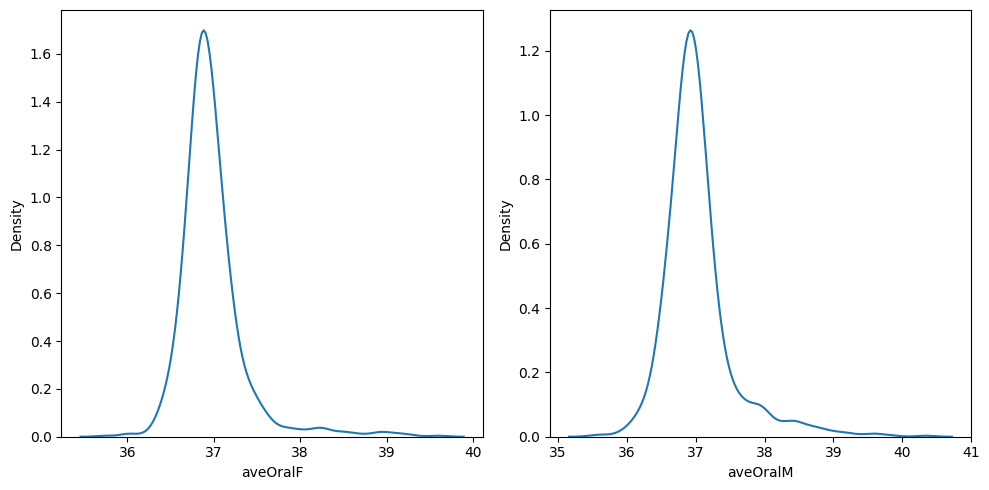

In [5]:
fig, ax = plt_kde_grid(y, num_cols = 2, fig_size = (10, 5))

We can see that the distributions have long tails and, therefore, are probabaly not quite normally distributed. We can test this with the Shapiro-Wilk test (scipy docs with references, [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)). We will store the names of variables for which the test indicates we should reject the null hypothesis (i.e., that the variable is normally distributed) to use later in creating our table one.

In [6]:
non_normal_vars = []
for c in y.columns:
    _, p_value = shapiro(y[c])
    print(f'p-value for {c} = {p_value}')
    if p_value < alpha:
        non_normal_vars.append(c)

p-value for aveOralF = 1.3765572641950405e-34
p-value for aveOralM = 7.657236028940027e-31


Indeed, the p-values returned by the Shapiro-Wilk test are well below any reasonable &alpha; threshold for rejecting the null hypothesis (typically 0.05 or 0.01), suggesting that we should consider these variables to be __not__ normally distributed. The implication is that in reporting on these data, we should prefer the median over the mean as a measure of centrality and the interquartile range (IQR) over the standard deviation as a measure of dispersiion. 

## Feature Data
Now let's examine the feature data. For the features that are continuous, we will plot the plot the distributions and test for normality as we did with the targtes. However, some of the features are nominal (categorical) for which we will prefer to view counts of each category.

First, let's count the number of rows with missing data from each column.

In [7]:
X.isna().sum()

Gender         0
Age            0
Ethnicity      0
T_atm          0
Humidity       0
Distance       2
T_offset1      0
Max1R13_1      0
Max1L13_1      0
aveAllR13_1    0
aveAllL13_1    0
T_RC1          0
T_RC_Dry1      0
T_RC_Wet1      0
T_RC_Max1      0
T_LC1          0
T_LC_Dry1      0
T_LC_Wet1      0
T_LC_Max1      0
RCC1           0
LCC1           0
canthiMax1     0
canthi4Max1    0
T_FHCC1        0
T_FHRC1        0
T_FHLC1        0
T_FHBC1        0
T_FHTC1        0
T_FH_Max1      0
T_FHC_Max1     0
T_Max1         0
T_OR1          0
T_OR_Max1      0
dtype: int64

We see that the `X.Distance` variable has two missing values. Let's take a look at these two rows in the cell block below. Later, we will cover imputation methods to deal with missing values before training our ML models.

In [8]:
X.loc[pd.isna(X['Distance']),:]

,Gender,Age,Ethnicity,T_atm,Humidity,Distance,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,T_RC_Wet1,T_RC_Max1,T_LC1,T_LC_Dry1,T_LC_Wet1,T_LC_Max1,RCC1,LCC1,canthiMax1,canthi4Max1,T_FHCC1,T_FHRC1,T_FHLC1,T_FHBC1,T_FHTC1,T_FH_Max1,T_FHC_Max1,T_Max1,T_OR1,T_OR_Max1
902,Female,18-20,White,23.9,15.3,NaN,0.8100,35.735,35.4150,35.0525,34.6275,35.7000,35.7000,35.5200,35.7350,35.4450,35.4100,35.290,35.460,35.3150,35.010,35.735,35.6975,34.5750,34.73,34.675,34.7075,34.77,35.3900,35.1925,36.0075,35.8675,35.895
903,Male,18-20,White,23.9,15.3,NaN,0.7775,35.620,35.6275,34.3650,33.8125,35.6675,35.5975,35.5925,35.7025,35.6425,35.5975,35.505,35.685,35.3475,35.295,35.725,35.6950,33.4375,33.59,33.840,33.1125,33.35,34.8675,34.4825,36.3350,36.0425,36.080


### Continuous Features
Now let's take a closer look at the continuous features. In the code cells below:
1. Plot the KDE of each continuous variable.
2. Print the result of the Shapiro-Wilk test and add any variables with a p-value &le; &alpha; to the `non_normal_vars` list
3. Examine the Pearson cross-correlation matrix. We will see later, that we may wish to keep only one feature among highly correlated features.

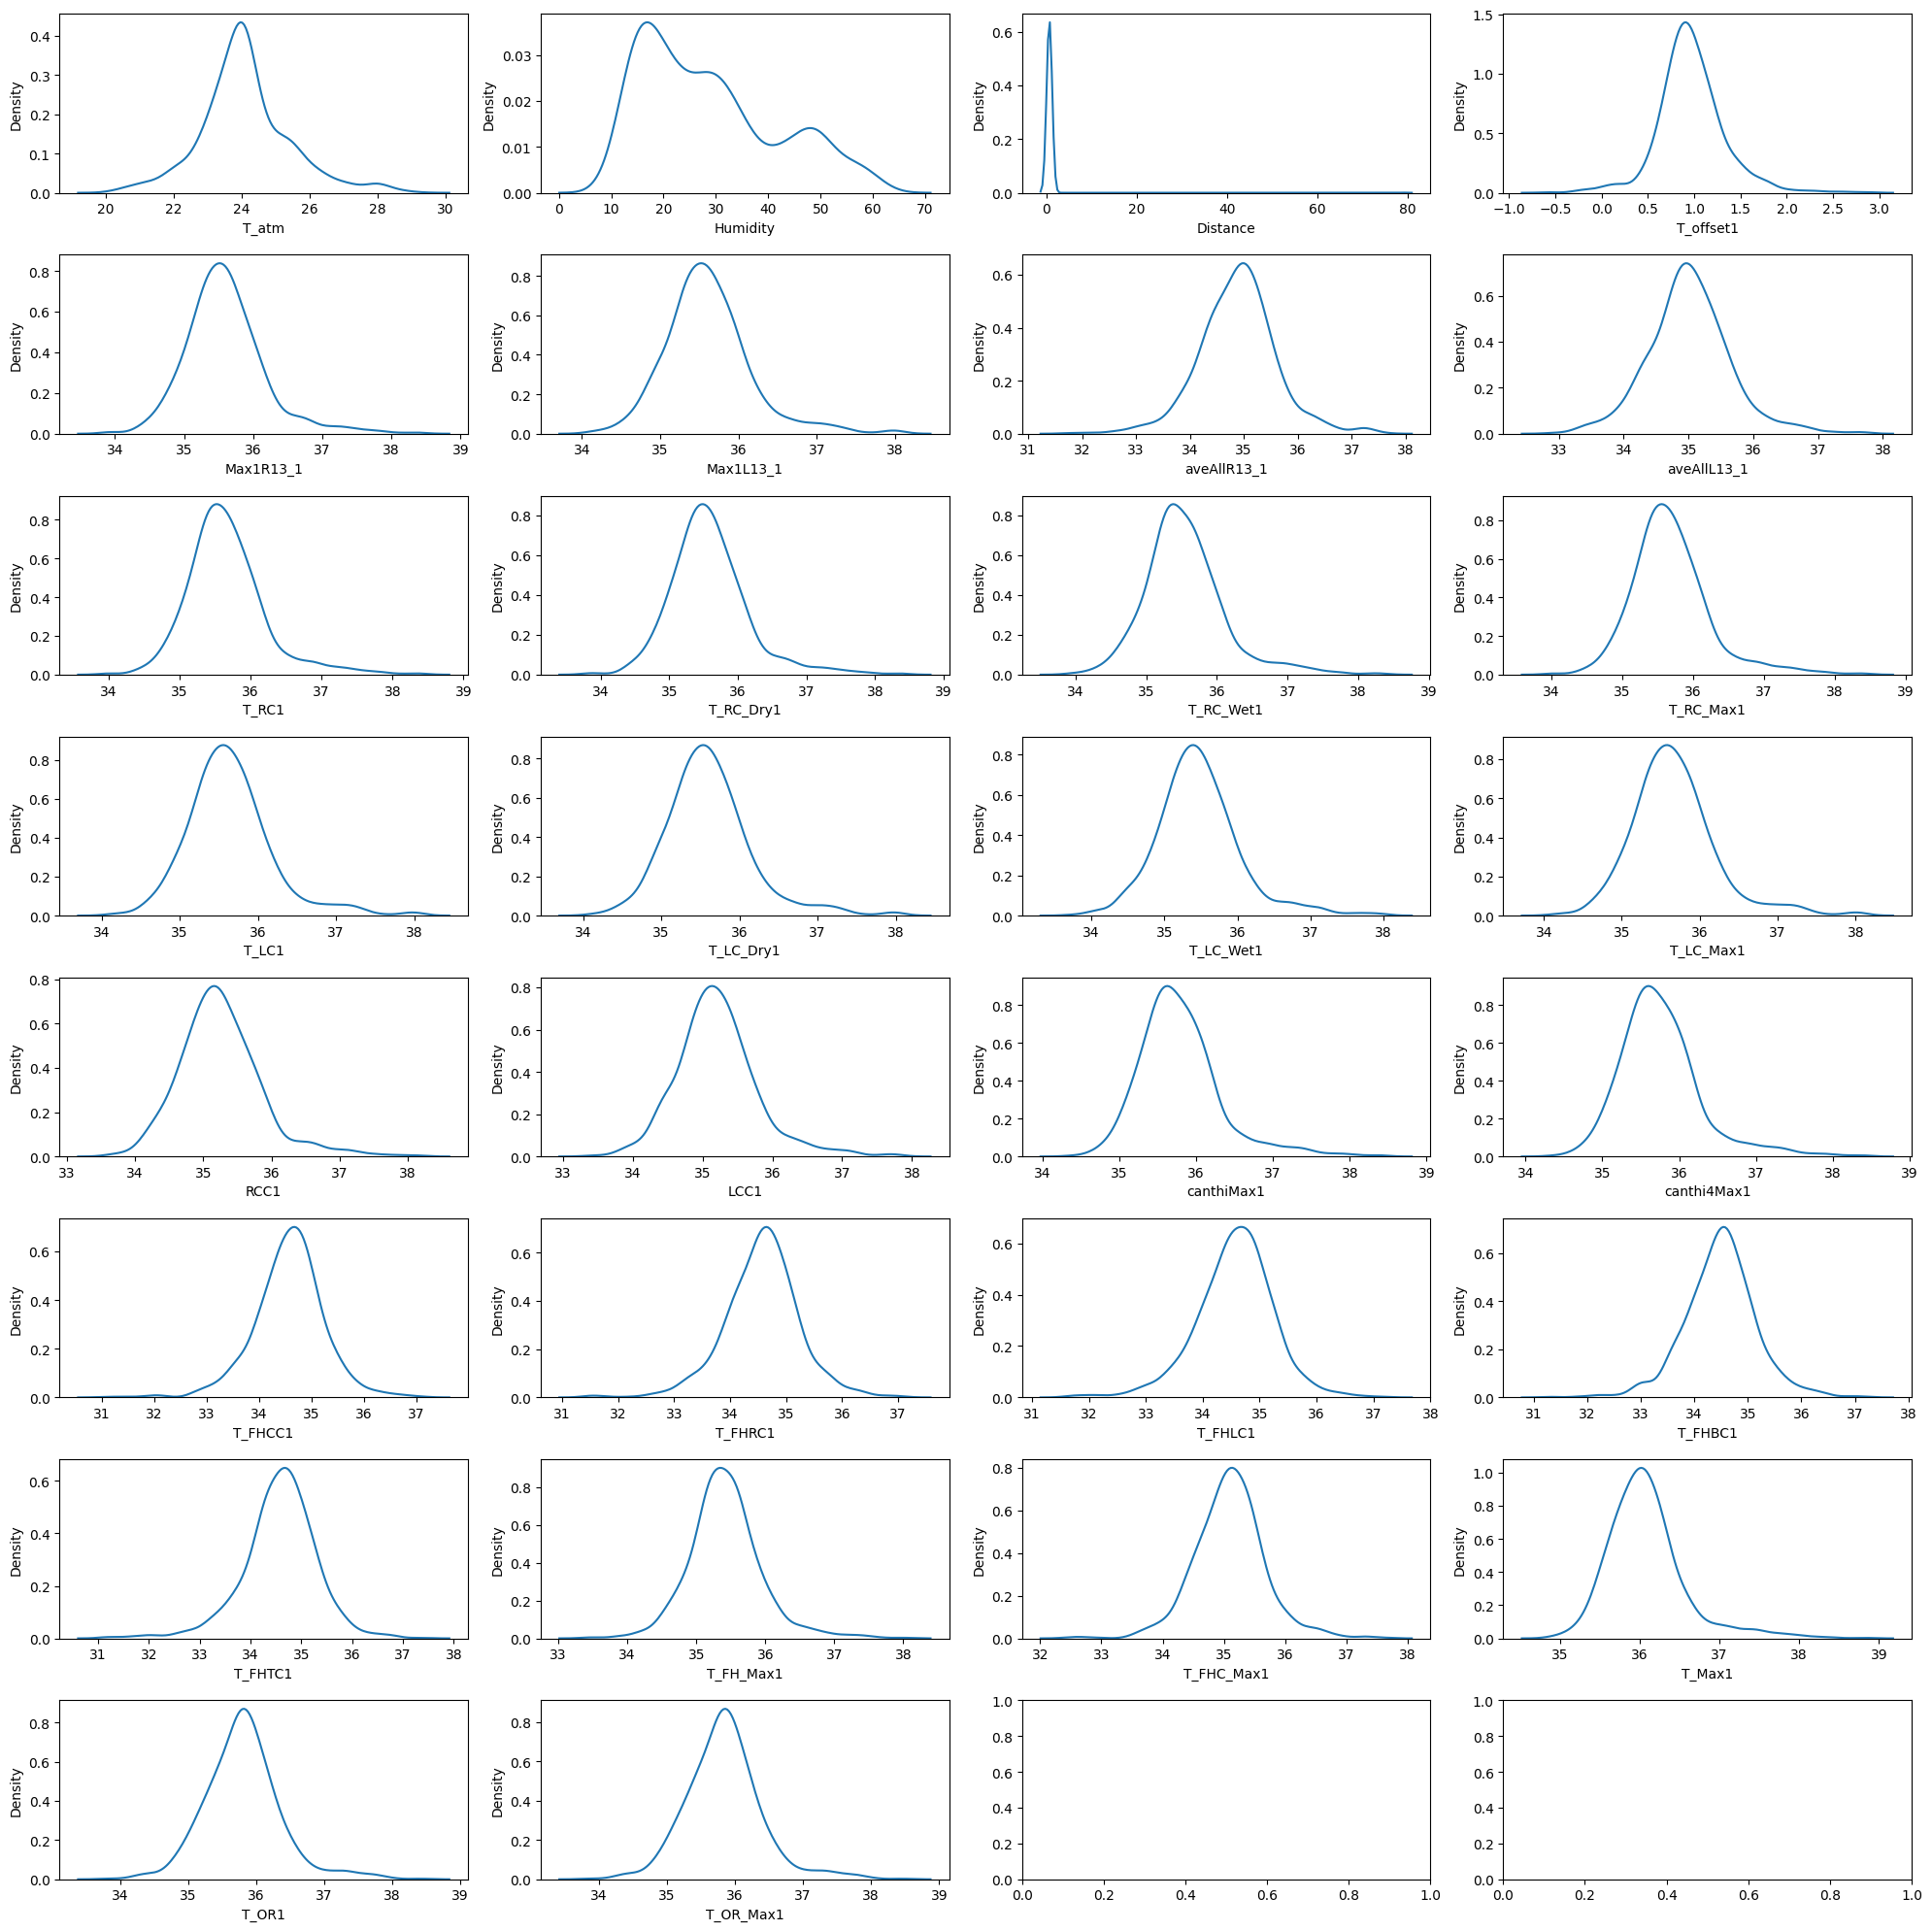

In [9]:

continuous_vars, X_continuous = get_vars_of_type(X, meta_vars, var_type_key = 'type', var_name_key = 'name', type_kw = 'Continuous')
fig, ax = plt_kde_grid(X_continuous, num_cols = 4, fig_size = (20, 20))

In [10]:
for c in X_continuous.columns:
    _, p_value = shapiro(X_continuous[c])
    print(f'p-value for {c} = {p_value}')
    if p_value < alpha:
        non_normal_vars.append(c)

p-value for T_atm = 2.5878546369348648e-15
p-value for Humidity = 7.652533906624954e-23
p-value for Distance = 1.0
p-value for T_offset1 = 5.858249848826621e-18
p-value for Max1R13_1 = 1.1182766370487076e-18
p-value for Max1L13_1 = 6.1166966409545264e-18
p-value for aveAllR13_1 = 2.0090915042736412e-10
p-value for aveAllL13_1 = 4.646954765430422e-10
p-value for T_RC1 = 2.7427111913756304e-20
p-value for T_RC_Dry1 = 3.211559230522218e-19
p-value for T_RC_Wet1 = 3.056406513989295e-19
p-value for T_RC_Max1 = 2.445355109240589e-20
p-value for T_LC1 = 1.3549560679597037e-18
p-value for T_LC_Dry1 = 4.285036282582936e-18
p-value for T_LC_Wet1 = 1.572071444884708e-16
p-value for T_LC_Max1 = 1.3530053692801505e-18
p-value for RCC1 = 7.39565840594758e-17
p-value for LCC1 = 1.3680445012971966e-15
p-value for canthiMax1 = 1.22908234786422e-21
p-value for canthi4Max1 = 1.3436913923231923e-21
p-value for T_FHCC1 = 9.30927752419708e-13
p-value for T_FHRC1 = 2.6543576364668198e-11
p-value for T_FHLC1 

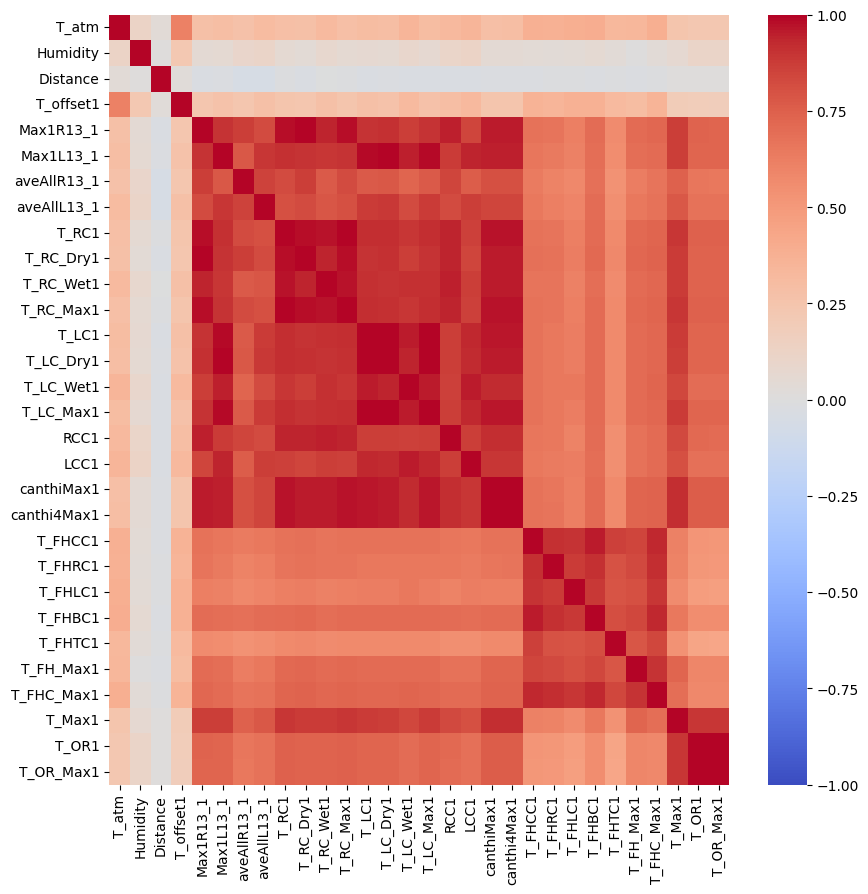

In [11]:
# plot the cross-correlation matrix of the continuous variables. Set the colorbar to be between -1 and 1
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(X_continuous.corr(), vmin = -1, vmax = 1, cmap = 'coolwarm', ax = ax)
plt.show()

### Categorical Features

For the categorical features, we want to compute the counts and percents of the labels within each category. First let's get the categorical features.

In [20]:
categorical_vars, X_categorical = get_vars_of_type(X, meta_vars, var_type_key = 'type', var_name_key = 'name', type_kw = 'Categorical')
for c in X_categorical.columns:
    counts = X_categorical[c].value_counts()
    percs = X_categorical[c].value_counts(normalize=True)*100
    print(f"{c}: {pd.concat([counts,percs], axis=1, keys=['count', 'percentage'])}")
    print('\n')

Gender:         count  percentage
Gender                   
Female    606   59.411765
Male      414   40.588235


Age:        count  percentage
Age                     
18-20    534   52.352941
21-25    355   34.803922
26-30     67    6.568627
31-40     31    3.039216
51-60     11    1.078431
21-30     10    0.980392
41-50      9    0.882353
>60        3    0.294118


Ethnicity:                                    count  percentage
Ethnicity                                           
White                                506   49.607843
Asian                                260   25.490196
Black or African-American            143   14.019608
Hispanic/Latino                       57    5.588235
Multiracial                           50    4.901961
American Indian or Alaskan Native      4    0.392157




# Table One
We can now put everything together in a Table One. This can be done manually using all the information we've developed above. Fortunately, this can also be produced using the [tableone package](https://tableone.readthedocs.io/en/latest/index.html).



In [13]:
mytable = TableOne(X, categorical = categorical_vars, nonnormal=non_normal_vars)
print(mytable.tabulate(tablefmt="fancy_grid"))
mytable.to_csv('../../data/outputs/tableone.csv')

╒═════════════════════════════╤═══════════════════════════════════╤═══════════╤══════════════════╕
│                             │                                   │ Missing   │ Overall          │
╞═════════════════════════════╪═══════════════════════════════════╪═══════════╪══════════════════╡
│ n                           │                                   │           │ 1020             │
├─────────────────────────────┼───────────────────────────────────┼───────────┼──────────────────┤
│ Gender, n (%)               │ Female                            │ 0         │ 606 (59.4)       │
├─────────────────────────────┼───────────────────────────────────┼───────────┼──────────────────┤
│                             │ Male                              │           │ 414 (40.6)       │
├─────────────────────────────┼───────────────────────────────────┼───────────┼──────────────────┤
│ Age, n (%)                  │ 18-20                             │ 0         │ 534 (52.4)       │
├─────────

# Data Normalization

## Continuous Variables
Empirical evidence suggests that most machine learning models perform better when continuous variables are standardized, i.e., transformed to have zero mean and unit variance, or scaled so that all variables fall within the same range, e.g. `[-1,1]`. This is particularly important when the features are on differenent sclales. For example, notice above, that the mean value of the `Distance` variable is `O(0.1)` while the rest of the variables are `O(10)`. The choice of standardizing vs. scaling may be dictated by the machine learning algorithm, some of which assume normality of the data. So even when the data is not strictly normal, we often ignore this and use standardized data when training a machine learning model.

Fortunately, there are libraries that include will allow us to easily scale the data. We will use [scikit-learn](https://scikit-learn.org/stable/index.html), which is amongst the most popular machine learning libraries. Later in the course, we will use these capabilities when we develop and evaluate our models.

First let's try standardizing the features. Notice we are using the Pandas `dropna` method to remove the two rows with missing data. 

In [14]:
scaler = preprocessing.StandardScaler().fit(X_continuous.dropna())
X_continuous_scaled = scaler.transform(X_continuous.dropna())

Now, let's look at the mean and standard deviation values of `X_continuous`. As we will see later, in supervised learning, we will divide our data in training and testing sets. When developing a mahcine learning model we always want to __avoid allowing test data characteristics to _leak_ into the training data__. This implies that we should compute the mean and standard deviation using only the training data and then scale the test data using the mean and standard deviation found for the training data. 

In [15]:
# view the mean values of each column in the data
display(scaler.mean_)

# view the standard devatiation of each column in the data
display(scaler.scale_)

# check that the means are 0 and the standard deviations are 1 in the scaled data
display(X_continuous_scaled.mean(axis = 0).round(2))
display(X_continuous_scaled.std(axis = 0).round(2))

display(pd.DataFrame(X_continuous_scaled, columns=X_continuous.columns).head())

array([24.11581532, 28.74941061,  0.72978389,  0.96899149, 35.59637361,
       35.61165111, 34.88882777, 35.01289948, 35.65987394, 35.58702194,
       35.54729699, 35.6897053 , 35.64104208, 35.61107973, 35.46876392,
       35.67115586, 35.25341028, 35.20907171, 35.78762197, 35.75814669,
       34.57498035, 34.56858301, 34.56594466, 34.48883595, 34.57830959,
       35.42212999, 35.094648  , 36.08461526, 35.80522511, 35.83798379])

array([ 1.33695964, 13.06447833,  2.45527922,  0.36268137,  0.57515322,
        0.549995  ,  0.71876038,  0.63291733,  0.55416731,  0.56954686,
        0.56910475,  0.55386418,  0.54139963,  0.54587647,  0.56668333,
        0.54097326,  0.60625483,  0.58464055,  0.53370902,  0.53356785,
        0.67184697,  0.66901712,  0.67860701,  0.66696501,  0.72799505,
        0.52344533,  0.576     ,  0.49199386,  0.55948024,  0.55953659])

array([-0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0., -0., -0., -0.,
       -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0., -0., -0.,  0.,
        0.,  0., -0., -0.])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

,T_atm,Humidity,Distance,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,T_RC_Wet1,T_RC_Max1,T_LC1,T_LC_Dry1,T_LC_Wet1,T_LC_Max1,RCC1,LCC1,canthiMax1,canthi4Max1,T_FHCC1,T_FHRC1,T_FHLC1,T_FHBC1,T_FHTC1,T_FH_Max1,T_FHC_Max1,T_Max1,T_OR1,T_OR_Max1
0,-0.086626,-0.057362,0.028598,-0.734781,-0.984735,-0.425733,-0.680098,-0.150730,-1.217816,-1.057019,-1.379003,-1.186582,-0.560662,-0.501175,-1.736003,-0.542829,-0.772629,-1.272699,-0.768437,-0.788366,-1.484684,-1.630875,-1.758668,-1.493835,-2.164588,-1.704342,-1.887410,-0.796992,-0.304256,-0.331495
1,-0.086626,-0.210449,0.028598,-0.521095,-1.819295,-1.984838,-1.334002,-1.244869,-1.714056,-1.675932,-1.594253,-1.710176,-1.996754,-1.966708,-1.974231,-2.026266,-1.535510,-1.657551,-1.962909,-1.955040,-0.807446,-0.767668,-1.309218,-0.777906,-0.790953,-1.413003,-0.754597,-1.848835,-1.273906,-1.305516
2,-0.086626,-0.210449,0.028598,-0.293623,0.097585,-0.171185,-0.850531,-0.336378,0.045340,0.141302,0.118964,0.050183,-0.255896,-0.198909,-0.306633,-0.260929,0.171693,-0.199390,-0.131386,-0.141775,0.483770,0.387011,0.120181,0.496524,0.125949,-0.147351,0.221965,-0.349832,0.097903,0.084027
3,-0.086626,-0.133906,0.028598,-0.107509,-0.650042,0.001543,-0.700968,0.370665,-0.816313,-0.679526,-0.755216,-0.839024,-0.085043,-0.029457,-0.249282,-0.108427,-0.566445,-0.066830,-0.328123,-0.305766,-0.200909,-0.218355,0.131233,-0.279379,0.465924,0.344582,0.382556,-0.741097,-1.501796,-1.528915
4,-0.086626,-0.133906,0.028598,-0.204012,-0.089322,0.096999,0.029457,0.560264,-0.103532,-0.196686,0.039893,-0.089743,-0.001925,0.052980,-0.690445,-0.006758,0.167569,-0.152353,-0.229754,-0.207371,0.766573,0.884009,-0.248221,0.271625,-1.031339,-0.008845,0.482382,-0.385402,-0.389156,-0.394047


In the code cell, below repeat the above procedure, but this time scale the data to be in `[-1,1]` using scikit-learn's `MinMaxScaler`. The transformation of a data array, `X` is given by:

```
X_std = (X-X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max-min) + min
```

In [16]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(X_continuous.dropna())
X_continuous_scaled = scaler.transform(X_continuous.dropna())

# view the min of each column in the data
display(scaler.data_min_)

# view the max of each column in the data
display(scaler.data_max_)

display(pd.DataFrame(X_continuous_scaled, columns=X_continuous.columns).head())

array([20.2   ,  9.9   ,  0.54  , -0.59  , 33.8975, 34.1225, 31.77  ,
       32.9025, 33.985 , 33.825 , 33.9325, 34.0025, 34.105 , 34.105 ,
       33.73  , 34.1225, 33.6175, 33.385 , 34.375 , 34.3525, 31.05  ,
       31.4525, 31.6575, 31.28  , 31.15  , 33.4075, 32.44  , 34.8925,
       33.8025, 33.835 ])

array([29.1   , 61.2   , 79.    ,  2.875 , 38.405 , 38.0425, 37.575 ,
       37.68  , 38.385 , 38.38  , 38.33  , 38.4075, 38.0425, 38.0375,
       37.96  , 38.075 , 38.155 , 37.8275, 38.4075, 38.3825, 37.125 ,
       37.075 , 37.165 , 37.2125, 37.3675, 38.0025, 37.6325, 38.8075,
       38.4175, 38.455 ])

,T_atm,Humidity,Distance,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,T_RC_Wet1,T_RC_Max1,T_LC1,T_LC_Dry1,T_LC_Wet1,T_LC_Max1,RCC1,LCC1,canthiMax1,canthi4Max1,T_FHCC1,T_FHRC1,T_FHLC1,T_FHBC1,T_FHTC1,T_FH_Max1,T_FHC_Max1,T_Max1,T_OR1,T_OR_Max1
0,-0.146067,-0.294347,-0.993372,-0.253968,-0.497504,-0.359694,-0.093885,-0.156463,-0.545455,-0.490670,-0.622513,-0.532350,-0.373968,-0.373172,-0.643026,-0.364959,-0.485399,-0.513787,-0.502790,-0.511166,-0.167901,-0.279680,-0.377213,-0.254109,-0.404101,-0.511425,-0.396245,-0.591315,-0.205850,-0.213203
1,-0.146067,-0.372320,-0.993372,-0.209235,-0.710483,-0.797194,-0.255814,-0.446363,-0.670455,-0.645445,-0.678226,-0.664018,-0.768889,-0.780038,-0.706856,-0.771031,-0.689256,-0.615082,-0.818971,-0.820099,-0.018107,-0.074255,-0.266455,-0.093131,-0.082429,-0.445049,-0.144921,-0.855683,-0.440953,-0.449134
2,-0.146067,-0.372320,-0.993372,-0.161616,-0.221298,-0.288265,-0.136090,-0.205651,-0.227273,-0.190999,-0.234792,-0.221339,-0.290159,-0.289256,-0.260047,-0.287793,-0.233058,-0.231289,-0.334160,-0.339950,0.267490,0.200534,0.085792,0.193426,0.132288,-0.156692,0.071738,-0.478927,-0.108342,-0.112554
3,-0.146067,-0.333333,-0.993372,-0.122655,-0.412091,-0.239796,-0.099053,-0.018315,-0.444318,-0.396268,-0.461057,-0.444949,-0.243175,-0.242212,-0.244681,-0.246047,-0.430303,-0.196398,-0.386237,-0.383375,0.116049,0.056470,0.088516,0.018963,0.211902,-0.044614,0.107366,-0.577267,-0.496208,-0.503247
4,-0.146067,-0.333333,-0.993372,-0.142857,-0.268996,-0.213010,0.081826,0.031920,-0.264773,-0.275521,-0.255259,-0.256527,-0.220317,-0.219326,-0.362884,-0.218216,-0.234160,-0.218908,-0.360198,-0.357320,0.330041,0.318808,-0.004993,0.142857,-0.138721,-0.125136,0.129514,-0.487867,-0.226436,-0.228355


## Nominal Features

Unlike continuous valued features, we do not standardize or scale categorical features. Most ofen, we will create dummy variables to replace the original categorical variable. For a given categorical variable, $x$, with $N$ possible values, we will replace $x$ with $N$ new values. Each of the new variables are binary valued. The value of the $n^{th}$ variable is set to 1 if $x$ is in the $n^{th}$ category and set to 0 otherwise.

For example, the `Gender` varialbe in this dataset can take the possible values `Female` and `Male`. To create dummy variables, we remove the `Gender` variable and create two new variables `Gender_male` and `Gender_female`. If the `Gender` variable is `Female`, the `Gender_female` is set to 1 and the `Gender_male` variable is set to 0. If the `Gender` variable is `Female`, the `Gender_female` is set to 1 and the `Gender_male` variable is set to 0. 

Let's see how to implement this for the `Gender` variable.

In [23]:
# create dummy variables for the Gender variable
X_categorical_dummy = pd.get_dummies(X_categorical, columns=categorical_vars,drop_first=False, dtype=int)
display(X_categorical_dummy.head())
#X.drop(columns=categorical_vars, inplace=True)
X_new = pd.concat([pd.DataFrame(X_continuous_scaled, columns=X_continuous.columns), X_categorical_dummy], axis=1)
display(X_new.head())


,Gender_Female,Gender_Male,Age_18-20,Age_21-25,Age_21-30,Age_26-30,Age_31-40,Age_41-50,Age_51-60,Age_>60,Ethnicity_American Indian or Alaskan Native,Ethnicity_Asian,Ethnicity_Black or African-American,Ethnicity_Hispanic/Latino,Ethnicity_Multiracial,Ethnicity_White
0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1


,T_atm,Humidity,Distance,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,T_RC_Wet1,T_RC_Max1,T_LC1,T_LC_Dry1,T_LC_Wet1,T_LC_Max1,RCC1,LCC1,canthiMax1,canthi4Max1,T_FHCC1,T_FHRC1,T_FHLC1,T_FHBC1,T_FHTC1,T_FH_Max1,T_FHC_Max1,T_Max1,T_OR1,T_OR_Max1,Gender_Female,Gender_Male,Age_18-20,Age_21-25,Age_21-30,Age_26-30,Age_31-40,Age_41-50,Age_51-60,Age_>60,Ethnicity_American Indian or Alaskan Native,Ethnicity_Asian,Ethnicity_Black or African-American,Ethnicity_Hispanic/Latino,Ethnicity_Multiracial,Ethnicity_White
0,-0.146067,-0.294347,-0.993372,-0.253968,-0.497504,-0.359694,-0.093885,-0.156463,-0.545455,-0.490670,-0.622513,-0.532350,-0.373968,-0.373172,-0.643026,-0.364959,-0.485399,-0.513787,-0.502790,-0.511166,-0.167901,-0.279680,-0.377213,-0.254109,-0.404101,-0.511425,-0.396245,-0.591315,-0.205850,-0.213203,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,-0.146067,-0.372320,-0.993372,-0.209235,-0.710483,-0.797194,-0.255814,-0.446363,-0.670455,-0.645445,-0.678226,-0.664018,-0.768889,-0.780038,-0.706856,-0.771031,-0.689256,-0.615082,-0.818971,-0.820099,-0.018107,-0.074255,-0.266455,-0.093131,-0.082429,-0.445049,-0.144921,-0.855683,-0.440953,-0.449134,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,-0.146067,-0.372320,-0.993372,-0.161616,-0.221298,-0.288265,-0.136090,-0.205651,-0.227273,-0.190999,-0.234792,-0.221339,-0.290159,-0.289256,-0.260047,-0.287793,-0.233058,-0.231289,-0.334160,-0.339950,0.267490,0.200534,0.085792,0.193426,0.132288,-0.156692,0.071738,-0.478927,-0.108342,-0.112554,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,-0.146067,-0.333333,-0.993372,-0.122655,-0.412091,-0.239796,-0.099053,-0.018315,-0.444318,-0.396268,-0.461057,-0.444949,-0.243175,-0.242212,-0.244681,-0.246047,-0.430303,-0.196398,-0.386237,-0.383375,0.116049,0.056470,0.088516,0.018963,0.211902,-0.044614,0.107366,-0.577267,-0.496208,-0.503247,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,-0.146067,-0.333333,-0.993372,-0.142857,-0.268996,-0.213010,0.081826,0.031920,-0.264773,-0.275521,-0.255259,-0.256527,-0.220317,-0.219326,-0.362884,-0.218216,-0.234160,-0.218908,-0.360198,-0.357320,0.330041,0.318808,-0.004993,0.142857,-0.138721,-0.125136,0.129514,-0.487867,-0.226436,-0.228355,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1


As a check on the dummy variable conversion, compute the percent of rows that have a value of 1 for each of the category types. These should match the percents we found for our Table 1.

In [25]:
# compute the percentage each dummy variable represents for its original categorical variable
N = len(X_new.index)
for prefix in ['Gender', 'Age', 'Ethnicity']:
    for col in X_new.columns:
        if col.startswith(prefix):
            print(f'{col}: {X_new[col].sum()/N*100:.2f}%')

Gender_Female: 59.41%
Gender_Male: 40.59%
Age_18-20: 52.35%
Age_21-25: 34.80%
Age_21-30: 0.98%
Age_26-30: 6.57%
Age_31-40: 3.04%
Age_41-50: 0.88%
Age_51-60: 1.08%
Age_>60: 0.29%
Ethnicity_American Indian or Alaskan Native: 0.39%
Ethnicity_Asian: 25.49%
Ethnicity_Black or African-American: 14.02%
Ethnicity_Hispanic/Latino: 5.59%
Ethnicity_Multiracial: 4.90%
Ethnicity_White: 49.61%
